# Neutron Burst

The neutron burst may happen in high mass stars during a supernova blast leaving behind its characteristic signatures in presolar grains. The neutron burst occurs when neutron number densities are sufficiently high ($\sim 10^{17}$) to capture up an isotopic chain in a manner similar to the r-process, though with much lower reaction rates and therefore less neutron rich products. 

Consider the following neutron capture chain:
\begin{gather}
1 + n \rightarrow 2 + \gamma\notag\\
2 + n \rightarrow 3 + \gamma\notag\\
3 + n \rightarrow 4 + \gamma\notag
\end{gather}

To solve this network numerically we have the coupled differential equations:
\begin{gather}
\frac{dY_1}{d\tau} = -\sigma_{n,1} Y_1\\
\frac{dY_2}{d\tau} = \sigma_{n,1} Y_1 - \sigma_{n,2}Y_2\\
\frac{dY_3}{d\tau} = \sigma_{n,2} Y_2 - \sigma_{n,3}Y_3\\
\frac{dY_4}{d\tau} = \sigma_{n,3} Y_3 
\end{gather}
where the $\sigma_n$ are the neutron capture cross sections for each species.

## Solving the network 

We begin by importing the necessary libraries:

In [2]:
import sys, subprocess, pkg_resources
import os, io, requests
required = {'numpy','wnutils', 'wnnet', 'matplotlib', 'gslconsts', 'scipy', 'ipywidgets'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    subprocess.check_call([sys.executable,'-m','pip','install','--quiet',*missing])

import wnnet as wn 
import wnutils.xml as wx
import matplotlib.pyplot as plt
import numpy as np
from gslconsts.consts import *
from scipy.integrate import solve_ivp

Now we define a function to integrate the network numerically:

In [3]:
def Y(t, y, sigs):
    N = len(y)
    result = np.zeros(N)
    result[0] = -sigs[0]*y[0]
    for i in range(1, N):
        result[i] = sigs[i-1]*y[i-1] - sigs[i]*y[i]
    return result

### Getting the initial abundances

As a starting point, we will take the initial abundances to be that of solar (Lodders 2023). To obtain the abundances we define a function that uses wnutils to read in a single-zone xml file pulled down from osf, given a list of isotopes in the chain:

In [4]:
def get_solar_isotopes(isotopes):
    solar_xml = wx.Xml(
        io.BytesIO(requests.get("https://osf.io/w8ktc/download").content))
    
    solar_data = solar_xml.get_zone_data()
    x_solar = solar_data["0"]["mass fractions"]

    abunds = []
    names = []
    a = []

    for isotope in isotopes:
        tup = solar_xml.get_z_a_state_from_nuclide_name(isotope)
        s_tup = (isotope, tup[0], tup[1])
        a.append(s_tup[2])
        names.append(isotope)
        if s_tup in x_solar:
            abunds.append(x_solar[s_tup] / tup[1])
        else:
            abunds.append(0)
            
    return a, names, abunds

Now we define a list of isotopes, which can be altered to whatever neutron capture chain is of interest to you. Additionally we define a dictionary which will later store the abundances.

In [5]:
species = ['ca40', 'ca41', 'ca42', 'ca43', 'ca44', 'ca45']
abund_dict = {}

Now we pull in the abundance xml and populate the abundance dictionary:

In [6]:
a, names, solar_abunds = get_solar_isotopes(species)
for i in range(len(abunds)):
    abund_dict[names[i]] = solar_abunds[i]

Now, we can plot the initial abundances:

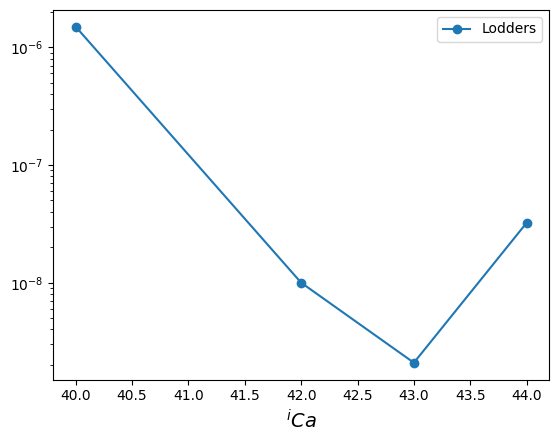

In [7]:
fig, ax = plt.subplots()
ax.plot([a[i] for i in range(len(abunds)) if abunds[i] !=0], 
        [vals for keys, vals in abund_dict.items() if vals != 0], 'o-', label = 'Lodders')
ax.set_yscale('log')
ax.set_xlabel(r'$^{i} Ca$', fontsize = 14)
ax.legend()
plt.show()

### Plotting the abundances vs. neutron exposure 

We can use the initial abundances and the scipy.integrate function to solve the system of ODE's presented above. In order to do this we need to obtain the neutron capture cross sections using the wnnet package. First, we obtain our nuclear network xml:

In [8]:
net = wn.net.Net(io.BytesIO(requests.get('https://osf.io/vqhxr/download').content))

Next, we define a temperature in $10^9$K to be used to compute the reaction rates. The "induced_nuc_xpath" selects a subset of the nuclei in the network. For our purposes in the neutron burst we must include neutrons (i.e. a=1 and z=0), but the additional xpath expression after "or" can be modified for any set of isotopes (e.g. z=40 and a-z >= 54 and a-z <= 60 would select zirconium isotopes between $^{94}$Zr and $^{100}$Zr). The "induced_reac_xpath" selects a subset of reactions and should not be changed as it selects only (n,$\gamma$) reactions.  

In [9]:
t9 = 10

induced_nuc_xpath = "[(a=1 and z=0) or (z = 20 and a - z >= 20 and a - z <= 30)]"
induced_reac_xpath = "[reactant = 'n' and product = 'gamma']"
reacs = net.compute_rates(t9, nuc_xpath = induced_nuc_xpath, reac_xpath = induced_reac_xpath)
rates = []
for key, values in list(reacs.items()):
    rates.append(values[0])
    print('reaction :', key, ';', 'Forward rate :', '{:.2e}'.format(values[0]))

reaction : n + ca44 -> ca45 + gamma ; Forward rate : 9.69e+05
reaction : n + ca43 -> ca44 + gamma ; Forward rate : 2.00e+06
reaction : n + ca46 -> ca47 + gamma ; Forward rate : 5.72e+05
reaction : n + ca42 -> ca43 + gamma ; Forward rate : 1.71e+06
reaction : n + ca45 -> ca46 + gamma ; Forward rate : 8.22e+05
reaction : n + ca47 -> ca48 + gamma ; Forward rate : 4.05e+05
reaction : n + ca49 -> ca50 + gamma ; Forward rate : 1.37e+05
reaction : n + ca40 -> ca41 + gamma ; Forward rate : 1.70e+06
reaction : n + ca41 -> ca42 + gamma ; Forward rate : 2.17e+06
reaction : n + ca48 -> ca49 + gamma ; Forward rate : 1.52e+05


The reaction dictionary returned by wnnet does not order the reactions by increasing neutron number, so next we create an ordered array of the cross sections along the path in the order of the neutron burst pathway:

In [23]:
species = ['ca40','ca41','ca42','ca43','ca44','ca45','ca46','ca47','ca48']
ordered_dict = {}

a, names, abunds = get_solar_isotopes(species)
for i in range(len(abunds)):
    abund_dict[names[i]] = abunds[i]

for sp in species:
    for key, value in net.get_reactions(reac_xpath = induced_reac_xpath).items():
        if sp in value.reactants:
            ordered_dict[sp] = reacs[key][0]

Now that we have obtained the rates, we can get the cross sections by noting:
\begin{gather}
r(T) = N_A <\sigma v>(T)
\end{gather}
and the thermal velocity is given by:
\begin{gather}
v_T = \sqrt{\frac{2k_BT}{m_n}}
\end{gather}
which represents the most probable velocity in a Maxwell-Boltzmann distribution. We then compute the cross sections:

In [24]:
k = GSL_CONST_CGS_BOLTZMANN
N_A = GSL_CONST_NUM_AVOGADRO
m_n = GSL_CONST_CGS_MASS_NEUTRON

T = t9 * 10**9
v_T = np.sqrt((2*k*T)/m_n)

#sigs = {}
sigs_array = []
for key, value in ordered_dict.items():
    sigs_array.append(1000*value/(v_T*N_A*wn.consts.GSL_CONST_CGSM_BARN))

Finally we compute the final abundances using the solve_ivp function:

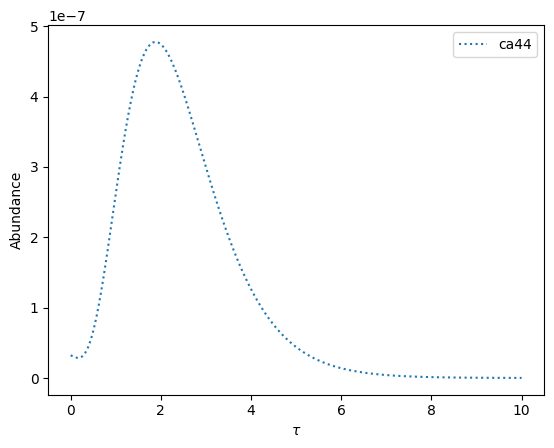

In [25]:
tau = np.linspace(0.001, 10, 100)

sol = solve_ivp(Y, [tau[0], tau[len(tau)-1]], abunds, args=(sigs_array,), max_step=0.02)

#plot results
fig, ax = plt.subplots()
ax.plot(sol.t, sol.y[4], ':', label = species[4])
plt.legend()
plt.xlabel(r'$\tau$')
plt.ylabel('Abundance')
plt.show()

### Exploring final abundances 
Finally, we would like to explore the final abundances of isotopes subject to different exposures. One would also likely want initial abundances to be near solar, however varying the initial compositions can impact the final abundances to more accurately describe the abundances observed in presolar grains. 

In [53]:
import ipywidgets as widgets
from ipywidgets import interact, fixed

def solve_ode_ivp(abundances, tau):
    y0 = list(abundances.values())  # Initial conditions
    tau_range = np.linspace(0.001, 10, 100)
    print(tau)

    # Solve the ODE using solve_ivp
    sol = solve_ivp(
        Y, 
        (tau_range[0], tau_range[len(tau_range)-1]), 
        y0, 
        t_eval=tau,
        args=(sigs_array,)
    )
    
    return sol.y

def plot_nuclear_network(tau, isotope_abundances, **percent_changes):
    # Adjust the abundances based on the percentage changes
    adj_abundances = {isotope: abundance * (1 + percent_changes[isotope + '_percent'] / 100)
                      for isotope, abundance in isotope_abundances.items()}
    
    # Solve the ODE with the adjusted abundances and given tau
    solution = solve_ode_ivp(adj_abundances, [tau])
    fig, ax = plt.subplots()
    ax.plot([a[i] for i in range(len(abunds)) if abunds[i] !=0], 
        [vals for keys, vals in isotope_abundances.items() if vals != 0], 'o-', label = 'Lodders')
    
    ax.plot([a[i] for i in range(len(solution)) if solution[i] > 1e-10], 
            [sols for sols in solution if sols > 1e-10], 'o-', label = 'Network')
    
    ax.set_xlabel(r'$^{i}Ca$')  #Modify element symbol for different abundance chain
    ax.set_ylabel('Abundance')
    ax.set_title(f'(τ={tau})')
    ax.set_yscale('log')
    ax.legend()
    plt.show()
    
def create_interactive_plot(isotope_abundances):
    sliders = {}
    for isotope in isotope_abundances:
        sliders[isotope + '_percent'] = widgets.FloatSlider(
            value=0, min=-100, max=100, step=1, description=f'{isotope} (%)'
        )

    # Use `interact` to dynamically create the plot with adjustable parameters
    interact(
        plot_nuclear_network,
        tau=widgets.FloatSlider(value=1.0, min=0.001, max=10.0, step=(10-0.001)/100, description='τ'),
        isotope_abundances=fixed(isotope_abundances),
        **sliders
    )

In [54]:
create_interactive_plot(abund_dict)

interactive(children=(FloatSlider(value=1.0, description='τ', max=10.0, min=0.001, step=0.09999000000000001), …